# **Medical Image Gen**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *STEP 1: TRAINING DATA COLLECTION*



> Appending data to csv and generating captions for images related to skin rash from kaggle

In [2]:
import os
import pandas as pd

# Path to the base directory containing disease folders
base_dir = '/content/drive/MyDrive/skin_dataset'  # Update this path to where your disease folders are stored

# Path to the existing CSV file
csv_file = 'skin_rash_dataset.csv'

# Check if the CSV file exists; if not, create it
if not os.path.isfile(csv_file):
    df = pd.DataFrame(columns=['image_path', 'caption'])
else:
    df = pd.read_csv(csv_file)

# Create a list to store new data
new_data = []

# Iterate through each folder in the base directory
for disease_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(folder_path):
        # Iterate through each image in the disease folder
        for image_name in os.listdir(folder_path):
            if image_name.endswith('.jpg') or image_name.endswith('.jpeg') or image_name.endswith('.png'):
                image_path = os.path.join(folder_path, image_name)
                caption = disease_folder.replace('_', ' ')  # Use the folder name as the caption
                new_data.append({'image_path': image_path, 'caption': caption}) # Append data as a dictionary to the list

# Create a new DataFrame from the collected data
new_df = pd.DataFrame(new_data)

# Concatenate the new DataFrame with the existing one
df = pd.concat([df, new_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_file, index=False)

print(f'Updated {csv_file} with {len(df)} records.')

Updated skin_rash_dataset.csv with 6739 records.


In [3]:
!pip install requests beautifulsoup4 selenium pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


> Web scraping script to fetch images related to skin rash diseases and save the images along with captions for text-to-image model

In [4]:
import requests
from bs4 import BeautifulSoup
import os
from PIL import Image
from io import BytesIO
import pandas as pd
import time
from urllib.parse import urljoin

# Define the base URL of the website
base_url = 'https://www.dermnetnz.org'

# Directory to save the images
image_dir = 'skin_rash_images'
os.makedirs(image_dir, exist_ok=True)

# Create a list to hold image paths and captions
image_paths = []
captions = []

# Define categories to scrape
categories = [
    'dermatitis',
    'eczema-herpeticum',
    'fungal-nail-infections',
    # Add more categories as needed
]

# Function to scrape a webpage
def scrape_page(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        print(f"Scraping URL: {url}")

        # Find image containers
        for img_tag in soup.find_all('img'):
            img_url = img_tag.get('src')
            if img_url:
                full_img_url = urljoin(base_url, img_url)
                caption = img_tag.get('alt', 'No Caption')
                print(f"Found image: {full_img_url} with caption: {caption}")

                # Download the image
                try:
                    img_response = requests.get(full_img_url, headers=headers)
                    img_response.raise_for_status()
                    img = Image.open(BytesIO(img_response.content))
                    img_name = os.path.join(image_dir, os.path.basename(full_img_url))
                    img.save(img_name)

                    # Save the path and caption
                    image_paths.append(img_name)
                    captions.append(caption)
                except Exception as e:
                    print(f"Failed to download image {full_img_url}: {e}")
            else:
                print("No src attribute found in img tag.")
    else:
        print(f"Failed to retrieve page {url}: Status code {response.status_code}")

# Scrape each category page
for category in categories:
    category_page_url = f'https://dermnetnz.org/topics/{category}'
    scrape_page(category_page_url)

# Save the collected data to a CSV file
df = pd.DataFrame({'image_path': image_paths, 'caption': captions})
df.to_csv('skin_rash_dataset.csv', index=False)

print(f'Scraped {len(image_paths)} images.')

# Optional: Rate limiting to prevent overloading the server
time.sleep(2)


Scraping URL: https://dermnetnz.org/topics/dermatitis
Found image: https://www.dermnetnz.org/_resources/themes/mercury/dist/images/svg/logo-white-tm.svg with caption: DermNet
Failed to download image https://www.dermnetnz.org/_resources/themes/mercury/dist/images/svg/logo-white-tm.svg: cannot identify image file <_io.BytesIO object at 0x7f9ae03a4450>
Found image: https://www.dermnetnz.org/_resources/themes/mercury/dist/images/svg/close.svg with caption: close
Failed to download image https://www.dermnetnz.org/_resources/themes/mercury/dist/images/svg/close.svg: cannot identify image file <_io.BytesIO object at 0x7f9ae03a4400>
Found image: https://www.dermnetnz.org/assets/images/dermnet-changes-4.webp with caption: 
Found image: https://www.dermnetnz.org/assets/svg/white-magnifying-glass.svg with caption: 
Failed to download image https://www.dermnetnz.org/assets/svg/white-magnifying-glass.svg: cannot identify image file <_io.BytesIO object at 0x7f9ae03a4e50>
Found image: https://www.de

## *STEP 2 Fine Tune Clip Model*

In [5]:
import pandas as pd

# Load the CSV file
csv_file = 'skin_rash_dataset.csv'  # Path to your CSV file
data = pd.read_csv(csv_file)

# Extract image paths and captions
image_paths = data['image_path'].tolist()
captions = data['caption'].astype(str).tolist()

In [6]:
''' yeh chal rha hai mat chedna isko'''
from PIL import Image
from transformers import CLIPProcessor
import torch
from torch.utils.data import Dataset

class RashDataset(Dataset):
    def __init__(self, image_paths, captions, processor):
        self.image_paths = image_paths
        self.captions = captions
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        # image = image.resize((224, 224))  # Resize image
        caption = self.captions[idx]
        inputs = self.processor(images=image, text=caption, return_tensors="pt")
        return {k: v.squeeze(0) for k, v in inputs.items()}


In [7]:
import torch
from torch.utils.data import DataLoader
from transformers import CLIPModel, CLIPProcessor
import gc
from torch.cuda.amp import GradScaler, autocast

# Load the pre-trained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Move model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clear cached memory
torch.cuda.empty_cache()

# Create a dataset and dataloader
dataset = RashDataset(image_paths, captions, clip_processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)  # Batch size = 1

# Enable mixed precision training (AMP)
clip_model.to(device)  # Ensure model is on GPU
scaler = GradScaler()

# Fine-tuning loop
clip_model.train()  # Ensure the model is in training mode
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=1e-5)
num_epochs = 3
gradient_accumulation_steps = 1  # Adjust as needed

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        with autocast():  # Automatically handle mixed precision
            inputs = {k: v.to(device) for k, v in batch.items()}  # Ensure inputs are on GPU

            outputs = clip_model(**inputs)

            if outputs.loss is not None:
                loss = outputs.loss / gradient_accumulation_steps
                scaler.scale(loss).backward()

                if (i + 1) % gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}, Loss: {loss.item() * gradient_accumulation_steps}")

        del inputs, outputs, batch
        torch.cuda.empty_cache()
        gc.collect()

# Save the fine-tuned CLIP model
clip_model.save_pretrained("./fine_tuned_clip")
clip_processor.save_pretrained("./fine_tuned_clip")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

[]

## *STEP 3: Loading Diffusion Model*





In [8]:
!pip install diffusers transformers accelerate


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

##  *STEP 4: Testing code a prompt*

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

<ipython-input-9-85b6cd30acaa>:63: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/150 [00:00<?, ?it/s]

<ipython-input-9-85b6cd30acaa>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


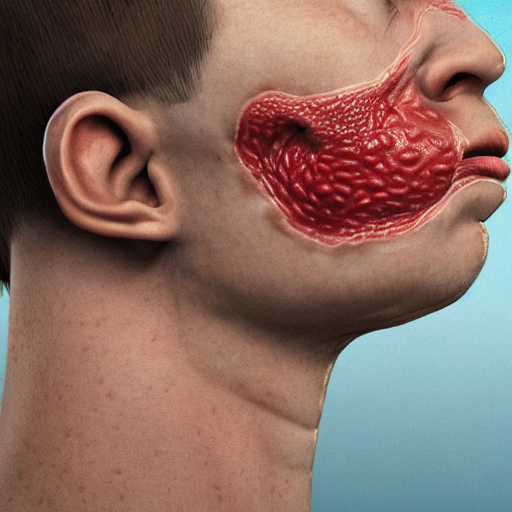

In [9]:

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from PIL import Image
from diffusers import LMSDiscreteScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# # 2. Load the tokenizer and text encoder to tokenize and encode the text.

tokenizer = CLIPTokenizer.from_pretrained("./fine_tuned_clip")
text_encoder = CLIPTextModel.from_pretrained("./fine_tuned_clip")


# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

from diffusers import DDIMScheduler
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


import torch

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


prompt = ["A realistic and detailed image depicting the neck of a person with fair skin. The neck shows a ringworm infection with a distinct circular red rash, featuring a slightly elevated, scaly border and a healthier-looking interior. The focus is on the neck and its accurate depiction of ringworm."]

height = 512
width = 512

num_inference_steps = 150

guidance_scale = 7.5

generator = torch.manual_seed(100)
batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma



from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample


  # scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

image = torch.tensor(image)
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]




## *STEP 5: Installing important liraries for creating interface using streamlit*

In [22]:
!npm install localtunnel


up to date, audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [10]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


## *STEP 6: Model Integration with streamlit UI*

In [40]:
%%writefile app.py

import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from PIL import Image
import streamlit as st
import io

# Load models
def load_models():
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda")
    tokenizer = CLIPTokenizer.from_pretrained("./fine_tuned_clip")
    text_encoder = CLIPTextModel.from_pretrained("./fine_tuned_clip").to("cuda")
    # tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    # text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to("cuda")
    scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    return vae, tokenizer, text_encoder, unet, scheduler

# Encode the prompt text
def encode_prompt(prompt, tokenizer, text_encoder):
    text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]

    uncond_input = tokenizer([""], padding="max_length", max_length=text_input.input_ids.shape[-1], return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]

    return torch.cat([uncond_embeddings, text_embeddings])

# Generate latents
def generate_latents(unet, scheduler, text_embeddings, height=512, width=512, steps=150, seed=100):
    generator = torch.manual_seed(seed)
    latents = torch.randn((1, unet.in_channels, height // 8, width // 8), generator=generator).to("cuda")
    scheduler.set_timesteps(steps)
    latents = latents * scheduler.init_noise_sigma

    progress_bar = st.progress(0)

    for i, t in enumerate(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

        progress_bar.progress(int((i + 1) / len(scheduler.timesteps) * 100))  # Update progress bar

    return latents

# Decode latents to an image
def decode_latents(vae, latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image[0])


# Main Streamlit app
def main():
    st.title("Skin Disease Image Generator")

    # Interactive Sidebar for Settings
    with st.sidebar:
        st.header("Settings")
        height = st.slider("Image Height", 256, 1024, 512, step=64)
        width = st.slider("Image Width", 256, 1024, 512, step=64)
        steps = st.slider("Number of Steps", 50, 300, 150, step=10)
        seed = st.number_input("Random Seed", value=100)

    # User input for the prompt
    prompt = st.text_area("Enter a prompt for the image generation:",
                          "A realistic and detailed image depicting the neck of a person with dark brown skin. The neck shows a ringworm infection with a distinct circular red rash, featuring a slightly elevated, scaly border and a healthier-looking interior. The focus is on the neck and its accurate depiction of ringworm.")

    # Create a placeholder for the loader
    loader_placeholder = st.empty()

    # Define HTML and CSS for the custom loader
    loader_html = """
    <style>

    .loader {
      --s: 25px;
      --g :5px;

      width: calc(3*(1.353*var(--s) + var(--g)));
      aspect-ratio: 3;
      background:
        linear-gradient(#ff1818 0 0) left/33% 100% no-repeat,
        conic-gradient(from -90deg at var(--s) calc(0.353*var(--s)),
          #fff 135deg,#666 0 270deg,#aaa 0);
      background-blend-mode: multiply;
      --_m:
        linear-gradient(to bottom right,
          #0000 calc(0.25*var(--s)),#000 0 calc(100% - calc(0.25*var(--s)) - 1.414*var(--g)),#0000 0),
        conic-gradient(from -90deg at right var(--g) bottom var(--g),#000 90deg,#0000 0);
      -webkit-mask: var(--_m);
              mask: var(--_m);
      background-size:   calc(100%/3) 100%;
      -webkit-mask-size: calc(100%/3) 100%;
              mask-size: calc(100%/3) 100%;
      -webkit-mask-composite: source-in;
              mask-composite: intersect;
      animation: l7 steps(3) 1.5s infinite;
    }
    @keyframes l7 {
      to {background-position: 150% 0%}
    }

    </style>
    <div class="loader"></div>
    """

    # Button to generate image
    if st.button("Generate Image"):
        # Show custom loader
        with loader_placeholder.container():
            st.markdown(loader_html, unsafe_allow_html=True)

            # Load models
            vae, tokenizer, text_encoder, unet, scheduler = load_models()

            # Encode prompt
            text_embeddings = encode_prompt(prompt, tokenizer, text_encoder)

            # Generate latents with progress bar
            latents = generate_latents(unet, scheduler, text_embeddings, height=height, width=width, steps=steps, seed=seed)

            # Decode latents to image
            pil_image = decode_latents(vae, latents)

        # Clear the placeholder and display the generated image
        loader_placeholder.empty()
        st.image(pil_image, caption="Generated Image", use_column_width=True)

        # Option to download the image
        buf = io.BytesIO()
        pil_image.save(buf, format="JPEG")
        byte_im = buf.getvalue()
        st.download_button(label="Download Image", data=byte_im, file_name="generated_image.jpg", mime="image/jpeg")

    # Footer
    st.markdown("""
    <style>
    footer {visibility: hidden;}
    </style>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Overwriting app.py


## *STEP 7: Command to run streamlit app.*
> The displayed IP will be password to be used to access the url generated below

In [ ]:
!streamlit run app.py --server.address=localhost &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.124.243.80
your url is: https://curly-cooks-repair.loca.lt
